# 5. Text Detection, Recognition & Spotting on the ArT Dataset


In this notebook, we will be learning how the text detection, recognition, and spotting tasks are done on the [ArT](https://rrc.cvc.uab.es/?ch=14&com=introduction) using methods for regular text, specifically EAST and CRNN with [PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR). For irregular text methods, [CRAFT](https://github.com/clovaai/CRAFT-pytorch) and ASTER (with [MMOCR](https://github.com/open-mmlab/mmocr)) will be used for text detection and text recognition respectively. We will first install and import necessary libraries and then define commonly used functions for creating models, inferencing images, and evaluating results. Lastly, we will compared the results of methods for regular text and irregular text.

**Table of Contents**

1. [Mount Google Drive](#mount-google-drive)
2. [Install PaddleOCR & MMOCR](#install-paddleocr-&-mmocr)
3. [Define Commonly Used Functions](#define-commonly-used-functions)
4. [Evaluate with Regular Text Methods](#evaluated-with-regular-text-methods)
5. [Evaluate with Irregular Text Methods](#evaluated-with-irregular-text-methods)
6. [Regular vs Irregular Text Methods](#regular-vs-irregular-text-methods)
7. [Conclusion](#conclusion)

Get your seatbelt on and let's get started! 🔥⭐


In [1]:
# CRAFT needs torchvision <= 0.13.0 to load model weights
!pip install torch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

<a name="mount-google-drive"></a>

## Mount Google Drive


In [2]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Chapter 6/ArT-20230605T061340Z-001.zip"

unzip:  cannot find or open /content/drive/MyDrive/Colab Notebooks/Chapter 6/ArT-20230605T061340Z-001.zip, /content/drive/MyDrive/Colab Notebooks/Chapter 6/ArT-20230605T061340Z-001.zip.zip or /content/drive/MyDrive/Colab Notebooks/Chapter 6/ArT-20230605T061340Z-001.zip.ZIP.


In [4]:
%cd "/content/drive/My Drive"
%cd "ArT"
!ls

/content/drive/My Drive
/content/drive/My Drive/ArT
ArT.zip  det.txt  rec.txt  selected  selected_crop  selected_labels.json


<a name="install-paddleocr-&-mmocr"></a>

## Install PaddleOCR & MMOCR


In [5]:
%cd "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/"
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
%cd ./PaddleOCR
!pip install -r requirements.txt
!pip install paddlepaddle
!pip install levenshtein

/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR
fatal: destination path 'PaddleOCR' already exists and is not an empty directory.
/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/PaddleOCR
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 9.6 MB/s eta 0:00:00


In [ ]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb

In [6]:
%cd "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_east"
!rm -rf *.tar*
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_mv3_east_v2.0_train.tar
!tar xvf det_mv3_east_v2.0_train.tar

%cd "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_crnn"
!rm -rf *.tar*
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/rec_mv3_none_bilstm_ctc_v2.0_train.tar
!tar xvf rec_mv3_none_bilstm_ctc_v2.0_train.tar


/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_east
--2023-06-15 00:56:42--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_mv3_east_v2.0_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33679360 (32M) [application/x-tar]
Saving to: ‘det_mv3_east_v2.0_train.tar’

det_mv3_east_v2.0_t 100%[===================>]  32.12M  7.80MB/s    in 22s     

2023-06-15 00:57:06 (1.46 MB/s) - ‘det_mv3_east_v2.0_train.tar’ saved [33679360/33679360]

det_mv3_east_v2.0_train/
det_mv3_east_v2.0_train/best_accuracy.pdparams
det_mv3_east_v2.0_train/best_accuracy.states
det_mv3_east_v2.0_train/best_accuracy.pdopt
det_mv3_east_v2.0_train/train.log
/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_crnn
--2023-06-15 00:57:07--  https://paddleo

In [7]:
!pip install -U openmim
!mim install mmengine==0.7.4
!mim install mmcv==2.0.0
!mim install mmdet==3.0.0
!mim install mmocr==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 4.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.12.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 24.3 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.3.0
    Uninstalling platformdirs-3.3.0:
      Successfully uninstalled platformdirs-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.12.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.3 MB/s eta 0:00:00
Looking in indexes: https://

In [8]:
from mmocr.apis import MMOCRInferencer

<a name="define-commonly-used-functions"></a>

## Define Commonly Used Functions


In [9]:
%cd "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/PaddleOCR"
!ls

/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/PaddleOCR
applications  doc	   paddleocr.py  README_ch.md	   StyleText
benchmark     __init__.py  ppocr	 README.md	   test_tipc
configs       LICENSE	   PPOCRLabel	 requirements.txt  tools
deploy	      MANIFEST.in  ppstructure	 setup.py	   train.sh


In [10]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import glob
import sys
import json
import yaml
import random
import shutil
import torch
import subprocess
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import typing
from typing import Dict, List, Optional

import paddle
from paddle import fluid
from ppocr.data import create_operators, transform
from ppocr.modeling.architectures import build_model
from ppocr.postprocess import build_post_process
from ppocr.utils.save_load import load_model
from ppocr.utils.utility import get_image_file_list
from shapely import Polygon

__dir__ = (
    "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/PaddleOCR"
)
sys.path.append(__dir__)
sys.path.append(os.path.abspath(os.path.join(__dir__, "..")))

from det_eval import evaluation, format_dict
from collections import defaultdict
from rec_eval import total_accuracy, total_edit_distance, normalized_edit_distance

In [11]:
def reset_dygraph():
    """Reset dygraph."""
    fluid.dygraph.disable_dygraph()
    fluid.dygraph.enable_dygraph()


def load_config(file_path: str):
    """Load PaddleOCR config (yml/yaml file).

    Args:
        file_path (str): Path of the config file.

    Returns:
        config (dict): Global config.
    """

    _, ext = os.path.splitext(file_path)
    assert ext in [".yml", ".yaml"], "only support yaml files for now"
    config = yaml.load(open(file_path, "rb"), Loader=yaml.Loader)
    return config

### Functions Related to Text Detection


In [12]:
def txt_to_dict(txt_path: str, include_trans: bool, sel_img_id: Optional[str] = None):
    """Construct an annotation dictionary based on txt file.

    Args:
        txt_path (str): Path to annotation/prediction in .txt file.
        include_trans (bool): Whether to include transcription.
        sel_img_id (str): Visualise this specific image only.

    Returns:
        anno_dict (Dict): A dict storing bounding boxes and transcriptions.
    """
    anno_dict = {}
    with open(txt_path, mode="r") as in_txt:
        lines = in_txt.readlines()
        for line in lines:
            line = line.strip()
            values = line.split("\t")
            img_id = values[0]

            if sel_img_id != None:
                if img_id != sel_img_id:
                    continue

            annos = json.loads(values[1])
            anno_dict[img_id] = annos

    return anno_dict


def det_eval(
    gt_path: str,
    det_path: str,
    eval_config: Dict,
    img_path: Optional[str] = None,
    vis_path: Optional[str] = None,
):
    """Evaluate detection result from .txt files.
       If img_path and vis_path are provided, it will save images with annotations.

    Args:
        gt_path (str): Path to ground-truth annotation in .txt file.
        det_path (str): Path to detection result in .txt file.
        eval_config (Dict): Evaluation configuration.
        img_path (str): Path to image for text detection.
        vis_path (str): Path to save result visualization.

    Returns:
        resDict (Dict): A dict storing overall and per-sample evaluation result.
    """

    if img_path != None and vis_path != None:
        print(f"Drawing detection results to {vis_path}.")
        if not os.path.exists(vis_path):
            os.makedirs(vis_path)
        draw_res = True
    else:
        draw_res = False

    if eval_config["WORD_SPOTTING"]:
        draw_trans = True
    else:
        draw_trans = False

    # Prepare GT
    gt_dict = txt_to_dict(gt_path, include_trans=True)

    # Prepare Det
    det_dict = defaultdict(list)
    det_dict = txt_to_dict(det_path, include_trans=eval_config["WORD_SPOTTING"])

    # write predictions to images
    if draw_res:
        for img_id in det_dict.keys():
            draw_det_res(
                gt_dict[img_id],
                det_dict[img_id],
                cv2.imread(os.path.join(img_path, img_id)),
                img_id,
                vis_path,
                draw_trans,
            )

    resDict = evaluation(gt_dict, det_dict, eval_config)
    return resDict


def draw_det_res(
    gt_list: List,
    det_list: List,
    img: np.ndarray,
    img_name: str,
    save_path: str,
    draw_trans: bool,
):
    """Draw detection result from PaddleOCR.
       Green box is ground-truth, red box is prediction.

    Args:
        gt_boxes (List[List]): List of ground-truth entries to be drawn on image.
        det_boxes (List[List]): List of prediction entries to be drawn on image.
        img (np.ndarray): Image to be drawn with dt_boxes.
        img_name (str): Output file name.
        save_path (str): Path to output folder.
        draw_trans (bool): Whether to write transcription on image.
    """
    if len(det_list) > 0:
        for gt_entry in gt_list:
            box = gt_entry["points"]
            cv2_points = np.array(box, np.int32).reshape(-1, 1, 2)
            trans = gt_entry["transcription"]

            if trans == "###":
                outline_color = (255, 0, 0)
            else:
                outline_color = (0, 255, 0)

            cv2.polylines(
                img, [cv2_points], isClosed=True, color=outline_color, thickness=2
            )

            if draw_trans:
                cv2.putText(
                    img,
                    trans,
                    (box[0][0], box[0][1]),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 255, 0),
                    thickness=2,
                )

        for det_entry in det_list:
            box = det_entry["points"]
            cv2_points = np.array(box, np.int32).reshape(-1, 1, 2)

            cv2.polylines(
                img, [cv2_points], isClosed=True, color=(0, 0, 255), thickness=2
            )

            if draw_trans:
                trans = det_entry["transcription"]
                cv2.putText(
                    img,
                    trans,
                    [box[0][0], box[0][1]],
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1,
                    color=(0, 0, 255),
                    thickness=2,
                )

        save_path = os.path.join(save_path, os.path.basename(img_name))
        cv2.imwrite(save_path, img)


def init_det(config_path: str, ft_model_path: Optional[str] = None):
    """Initialise detection model of PaddleOCR.

    Args:
        config_path (str): Path to config.
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.

    Returns:
        config (dict): Config.
        model (torch.nn.Module): Detection model built from config.
        ops (List): List of pre-processing operation.
        post_process_class (typing.Any): Object for post-processing.
    """
    config = load_config(config_path)
    global_config = config["Global"]
    if ft_model_path != None:
        global_config["pretrained_model"] = ft_model_path

    # build model
    model = build_model(config["Architecture"])

    load_model(config, model)
    # build post process
    post_process_class = build_post_process(config["PostProcess"])

    # create data ops
    transforms = []
    for op in config["Eval"]["dataset"]["transforms"]:
        op_name = list(op)[0]
        if "Label" in op_name:
            continue
        elif op_name == "KeepKeys":
            op[op_name]["keep_keys"] = ["image", "shape"]
        transforms.append(op)

    ops = create_operators(transforms, global_config)

    model.eval()
    return config, model, ops, post_process_class


def det_ppocr(
    out_path: str,
    det_yml: str,
    img_path: str,
    out_txt_name: str,
    ft_model_path: Optional[str] = None,
):
    """Carry out text detection using PaddleOCR.

    Args:
        out_path (str): Path to save detection result.
        det_yml (str): Path to detection config file (yml/yaml).
        img_path (str): Path to image for text detection.
        out_txt_name (str): File name to save detection output.
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.
    """
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    # Paddle OCR Configs
    detConfig, detModel, detOPS, detPost = init_det(det_yml, ft_model_path)

    images = glob.glob(os.path.join(img_path, "*"))  # load images

    with open(os.path.join(out_path, f"{out_txt_name}.txt"), mode="w") as out_f:
        for idx, img_name in enumerate(tqdm(images)):
            bbox_outputs = []
            with open(img_name, "rb") as f:
                img = f.read()
                data = {"image": img}

            batch = transform(data, detOPS)
            images = np.expand_dims(batch[0], axis=0)
            shape_list = np.expand_dims(batch[1], axis=0)
            images = paddle.to_tensor(images)

            # forward & post process
            preds = detModel(images)
            det_res = detPost(preds, shape_list)

            # parse boxes if post_result is dict
            if isinstance(det_res, dict):
                for k in det_res.keys():
                    boxes = det_res[k][0]["points"]
            else:
                boxes = det_res[0]["points"]

            boxes_len = len(boxes)
            if boxes_len == 0:
                print(
                    f"No output for {os.path.basename(img_name)}, bbox_len: {boxes_len}"
                )
                continue
            else:
                for box in boxes:
                    box_list = box.tolist()
                    poly = Polygon(box_list)

                    if poly.is_valid:
                        current_res_dict = {"points": box_list}
                        bbox_outputs.append(current_res_dict)

            out_f.write(f"{os.path.basename(img_name)}\t{json.dumps(bbox_outputs)}\n")

### Functions Related to Text Recognition


In [13]:
def data_prep_rec_eval(gt_path: str, rec_path: str):
    """Prepare ground-truth and prediction lists from .txt files for
    computing accuracy and edit distance for text recognition.

    Args:
        gt_path (str): Path to ground-truth annotation in .txt file.
        rec_path (str): Path to recognition result in .txt file.

    Returns:
        gt (list): List of texts from ground-truth annotation files.
        pred (list): List of texts from prediction.
    """
    # Prepare GT
    gt_dict = {}
    with open(gt_path, mode="r") as in_txt:
        lines = in_txt.readlines()
        for line in lines:
            line = line.strip()
            values = line.split("\t")
            img_id = values[0]
            gt_dict[img_id] = values[1]

    # Prepare Det
    det_dict = {}
    with open(rec_path, mode="r") as in_txt:
        lines = in_txt.readlines()
        for line in lines:
            line = line.strip()
            values = line.split("\t")
            img_id = values[0]
            if len(values) == 2:
                det_dict[img_id] = values[1]
            else:
                det_dict[img_id] = ""

    gt = []
    pred = []

    for key, val in gt_dict.items():
        if key in det_dict.keys():
            gt.append(val)
            pred.append(det_dict[key])

    return gt, pred


def init_rec(config_path: str, ft_model_path: Optional[str] = None):
    """Initialise recognition model of PaddleOCR

    Args:
        config_path (str): Path to config
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.

    Returns:
        config (dict): Config
        model (torch.nn.Module): Recognition model built from config
        ops (List): List of pre-processing operation
        post_process_class (typing.Any): Object for post-processing
    """
    config = load_config(config_path)
    global_config = config["Global"]
    if ft_model_path != None:
        global_config["pretrained_model"] = ft_model_path

    # build post process
    post_process_class = build_post_process(config["PostProcess"], global_config)

    # build model
    if hasattr(post_process_class, "character"):
        char_num = len(getattr(post_process_class, "character"))
        if config["Architecture"]["algorithm"] in [
            "Distillation",
        ]:  # distillation model
            for key in config["Architecture"]["Models"]:
                if (
                    config["Architecture"]["Models"][key]["Head"]["name"] == "MultiHead"
                ):  # for multi head
                    out_channels_list = {}
                    if config["PostProcess"]["name"] == "DistillationSARLabelDecode":
                        char_num = char_num - 2
                    out_channels_list["CTCLabelDecode"] = char_num
                    out_channels_list["SARLabelDecode"] = char_num + 2
                    config["Architecture"]["Models"][key]["Head"][
                        "out_channels_list"
                    ] = out_channels_list
                else:
                    config["Architecture"]["Models"][key]["Head"][
                        "out_channels"
                    ] = char_num
        elif (
            config["Architecture"]["Head"]["name"] == "MultiHead"
        ):  # for multi head loss
            out_channels_list = {}
            if config["PostProcess"]["name"] == "SARLabelDecode":
                char_num = char_num - 2
            out_channels_list["CTCLabelDecode"] = char_num
            out_channels_list["SARLabelDecode"] = char_num + 2
            config["Architecture"]["Head"]["out_channels_list"] = out_channels_list
        else:  # base rec model
            config["Architecture"]["Head"]["out_channels"] = char_num

    model = build_model(config["Architecture"])

    load_model(config, model)

    # create data ops
    transforms = []
    for op in config["Eval"]["dataset"]["transforms"]:
        op_name = list(op)[0]
        if "Label" in op_name:
            continue
        elif op_name in ["RecResizeImg"]:
            op[op_name]["infer_mode"] = True
        elif op_name == "KeepKeys":
            if config["Architecture"]["algorithm"] == "SRN":
                op[op_name]["keep_keys"] = [
                    "image",
                    "encoder_word_pos",
                    "gsrm_word_pos",
                    "gsrm_slf_attn_bias1",
                    "gsrm_slf_attn_bias2",
                ]
            elif config["Architecture"]["algorithm"] == "SAR":
                op[op_name]["keep_keys"] = ["image", "valid_ratio"]
            elif config["Architecture"]["algorithm"] == "RobustScanner":
                op[op_name]["keep_keys"] = ["image", "valid_ratio", "word_positons"]
            else:
                op[op_name]["keep_keys"] = ["image"]
        transforms.append(op)
    global_config["infer_mode"] = True
    ops = create_operators(transforms, global_config)

    model.eval()
    return config, model, ops, post_process_class


def rec_ppocr(
    out_path: str,
    reg_yml: str,
    img_path: str,
    out_txt_name: str,
    ft_model_path: Optional[str] = None,
):
    """Carry out text recognition using PaddleOCR

    Args:
        out_path (str): Path to save recognition result
        reg_yml (str): Path to recognition config file (yml/yaml)
        img_path (str): Path to image for text recognition
        out_txt_name (str): File name to save recognition output
        ft_model_path (Optional[str], optional): Path to pre-trained model. Defaults to None.
    """
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    # Paddle OCR Configs
    recConfig, recModel, recOPS, recPost = init_rec(reg_yml, ft_model_path)

    images = glob.glob(os.path.join(img_path, "*"))  # load images

    with open(os.path.join(out_path, f"{out_txt_name}.txt"), mode="w") as out_f:
        for idx, img_name in enumerate(tqdm(images)):
            with open(img_name, "rb") as f:
                img = f.read()
                data = {"image": img}
            batch = transform(data, recOPS)
            images = np.expand_dims(batch[0], axis=0)
            images = paddle.to_tensor(images)
            preds = recModel(images)

            rec_res = recPost(preds)
            formatted_res = rec_res[0][0].replace(" ", "")
            out_f.write(f"{os.path.basename(img_name)}\t{formatted_res}\n")


def vis_rec_res(gt_path: str, pt_path: str, ft_path: str, sel_img_id: str):
    """Visualise the prediction results

    Args:
        gt_path (str): Path to text recognition ground-truth in .txt file.
        pt_path (str): Path to text recognition prediction of pre-trained model in .txt file.
        ft_path (str): Path to text recognition prediction of fine-tuned model in .txt file.
        sel_img_id (str): Selected image to visualise.

    Returns:
        gt_trans (str): Ground-truth transcription.
        pt_trans (str): Predicted transcription using pre-trained model.
        ft_trans (str): Predicted transcription using fine-tuned model.
    """

    paths = [gt_path, pt_path, ft_path]
    trans_list = []

    for path in paths:
        with open(path, mode="r") as in_txt:
            lines = in_txt.readlines()
            for line in lines:
                line = line.strip()
                values = line.split("\t")
                img_id = values[0]

                if img_id == sel_img_id:
                    trans_list.append(values[1])

    assert len(trans_list) == 3, f"Invalid trans_list length: {len(trans_list)}"
    gt_trans = trans_list[0]
    pt_trans = trans_list[1]
    ft_trans = trans_list[2]

    return gt_trans, pt_trans, ft_trans

### Functions Related to Text Spotting


In [14]:
def spot_ppocr(
    tmp_folder_path: str,
    out_path: str,
    det_yml: str,
    reg_yml: str,
    img_path: str,
    out_txt_name: str,
    det_ft_model_path: Optional[str] = None,
    rec_ft_model_path: Optional[str] = None,
):
    """Chaining text detection and recognition end-to-end using PaddleOCR.

    Args:
        tmp_folder_path (str): Temporary folder path to store intermediate output.
        out_path (str): Path to save text spotting result
        det_yml (str): Path to detection config file (yml/yaml)
        reg_yml (str): Path to recognition config file (yml/yaml)
        img_path (str): Path to image for text spotting
        out_txt_name (str): File name to save detection output
        det_ft_model_path (Optional[str], optional): Path to text detection pre-trained model. Defaults to None.
        rec_ft_model_path (Optional[str], optional): Path to text recognition pre-trained model. Defaults to None.
    """
    if os.path.isdir(tmp_folder_path):
        shutil.rmtree(tmp_folder_path)

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    # Paddle OCR Configs
    detConfig, detModel, detOPS, detPost = init_det(det_yml, det_ft_model_path)
    recConfig, recModel, recOPS, recPost = init_rec(reg_yml, rec_ft_model_path)

    images = glob.glob(os.path.join(img_path, "*"))  # load images

    output_dict = defaultdict(list)

    with open(os.path.join(out_path, f"{out_txt_name}.txt"), mode="w") as out_f:
        for idx, img_name in enumerate(tqdm(images)):
            img_id = os.path.basename(img_name)

            # -------------------------------- STAGE I DETECTION ------------------------------
            with open(img_name, "rb") as f:
                img = f.read()
                data = {"image": img}

            batch = transform(data, detOPS)
            images = np.expand_dims(batch[0], axis=0)
            shape_list = np.expand_dims(batch[1], axis=0)
            images = paddle.to_tensor(images)

            # forward & post process
            preds = detModel(images)
            det_res = detPost(preds, shape_list)

            # parse boxes if post_result is dict
            if isinstance(det_res, dict):
                for k in det_res.keys():
                    boxes = det_res[k][0]["points"]
            else:
                boxes = det_res[0]["points"]

            # Crop to patches
            ori_img = cv2.imread(img_name)
            h, w, c = ori_img.shape
            if not os.path.exists(tmp_folder_path):
                os.mkdir(tmp_folder_path)

            for i, box in enumerate(boxes):
                pt = box.tolist()
                poly = Polygon(pt)
                if not poly.is_valid:
                  continue

                try:
                    xs = [x[0] for x in pt]
                    xs = np.clip(np.array(xs), a_min=0, a_max=w).tolist()
                    ys = [x[1] for x in pt]
                    ys = np.clip(np.array(ys), a_min=0, a_max=h).tolist()
                    minx = min(xs)
                    miny = min(ys)
                    maxx = max(xs)
                    maxy = max(ys)

                    if (maxx - minx) <= 0 or (maxy - miny) <= 0:
                        print(
                            "BBOX error occured when cropping image"
                            f" {os.path.basename(img_name)} of {i}-th box"
                        )
                        print(f"Processed BBOX {minx} {miny} {maxx} {maxy}")
                        print(f"Ori BBOX {pt}")
                        continue

                    crop = ori_img[miny:maxy, minx:maxx]
                    tmp_img_name = os.path.join(
                        "{}/{}_{}.jpg".format(
                            tmp_folder_path,
                            img_name.split("/")[-1].split(".")[0],
                            str(i),
                        )
                    )
                    cv2.imwrite(tmp_img_name, crop)
                except Exception as e:
                    print(
                        f"Error {e} occured when cropping image"
                        f" {os.path.basename(img_name)} of {i}-th box"
                    )
                    continue

            boxes_len = len(boxes)
            tmp_folder_len = len(os.listdir(tmp_folder_path))
            if boxes_len == 0 or tmp_folder_len == 0:
                print(
                    f"No output for {os.path.basename(img_name)}, bbox_len:"
                    f" {boxes_len}, tmp_len: {tmp_folder_len}"
                )
                shutil.rmtree(tmp_folder_path)
                continue

            if boxes_len != tmp_folder_len:
                print(
                    f"mismatch bbox_len {boxes_len} and tmp_len {tmp_folder_len} for"
                    f" image {os.path.basename(img_name)}"
                )
                shutil.rmtree(tmp_folder_path)
                continue

            # ------------------------- Stage II Recognition ------------------------------
            for file in get_image_file_list(tmp_folder_path):
                with open(file, "rb") as f:
                    img = f.read()
                    data = {"image": img}
                batch = transform(data, recOPS)
                images = np.expand_dims(batch[0], axis=0)
                images = paddle.to_tensor(images)
                preds = recModel(images)

                rec_res = recPost(preds)
                formatted_res = rec_res[0][0].replace(" ", "")

                b_id = int(file.split("_")[-1].replace(".jpg", ""))
                crt_box = boxes[b_id]

                output_dict[img_id].append(
                    {
                        "points": crt_box.tolist(),
                        "transcription": formatted_res,
                    }
                )

            shutil.rmtree(tmp_folder_path)

            out_f.write(f"{img_id}\t{json.dumps(output_dict[img_id])}\n")


In [15]:
def spot_craft_mmocr(
    out_txt_name: str,
    out_root_dir: str,
    ori_img_root_dir: str,
    craft_code_dir: str,
    rec_method: str = "aster",
):
    """Chaining text detection and recognition end-to-end using CRAFT and ASTER(MMOCR).

    Args:
        out_txt_name (str): File name to save detection output
        out_root_dir (str): Root directory for saving results
        ori_img_root_dir (str): Path to original images to be tested
        craft_code_dir (str): Path to CRAFT's code
        rec_method (str, optional): Recognition method to be used. Defaults to 'aster'.
            For more details, refer to MMOCR's documentation https://mmocr.readthedocs.io/en/dev-1.x/textrecog_models.html.
    """
    out_file_dir = os.path.join(out_root_dir, out_txt_name)

    tmp_folder_path = os.path.join(out_file_dir, "tmp")
    tmp_folder_vis_path = os.path.join(out_file_dir, "tmp", "vis")

    craft_result_dir = os.path.join(craft_code_dir, "result")
    if not os.path.exists(out_file_dir):
        os.makedirs(out_file_dir)

    with open(os.path.join(out_file_dir, out_txt_name + ".txt"), "w") as out_f:
        # -------------------------------- STAGE I DETECTION ------------------------------
        cmd = [
            "python",
            os.path.join(craft_code_dir, "test.py"),
            "--trained_model",
            os.path.join(craft_code_dir, "craft_mlt_25k.pth"),
            "--test_folder",
            ori_img_root_dir,
            "--cuda",
            f"{torch.cuda.is_available()}",
            "--poly",
        ]
        subprocess.run(cmd, capture_output=False, text=True)

        for res_file in glob.glob(os.path.join(craft_result_dir, "*.txt")):
            if os.path.exists(tmp_folder_path):
                shutil.rmtree(tmp_folder_path)
            os.makedirs(tmp_folder_vis_path)

            img_name = (
                os.path.basename(res_file).replace("res_", "").replace(".txt", ".jpg")
            )
            img_path = os.path.join(ori_img_root_dir, img_name)

            ori_img = cv2.imread(img_path)
            h, w, c = ori_img.shape

            with open(res_file, "r") as f:
                lines = f.readlines()

            boxes = {}
            for i, line in enumerate(lines):
                line = line.strip().split(",")
                points = [int(i) for i in line]
                xs = points[::2]
                ys = points[1::2]
                boxes[i] = list([x, y] for x, y in zip(xs, ys))

                poly = Polygon(boxes[i])

                if not poly.is_valid:
                    continue

                try:
                    xs = np.clip(np.array(xs), a_min=0, a_max=w).tolist()
                    ys = np.clip(np.array(ys), a_min=0, a_max=h).tolist()
                    minx = min(xs)
                    miny = min(ys)
                    maxx = max(xs)
                    maxy = max(ys)

                    if (maxx - minx) <= 0 or (maxy - miny) <= 0:
                        print(
                            "BBOX error occured when cropping image"
                            f" {img_name} of {i}-th box"
                        )
                        print(f"Processed BBOX {minx} {miny} {maxx} {maxy}")
                        print(f"Ori BBOX {pt}")
                        continue

                    crop = ori_img[miny:maxy, minx:maxx]
                    tmp_img_name = os.path.join(
                        "{}/{}_{}.jpg".format(
                            tmp_folder_vis_path,
                            img_name.split(".")[0],
                            str(i),
                        )
                    )
                    cv2.imwrite(tmp_img_name, crop)
                except Exception as e:
                    print(
                        f"Error {e} occured when cropping image {img_name} of"
                        f" {i}-th box"
                    )
                    continue
            boxes_len = len(boxes)
            tmp_folder_len = len(os.listdir(tmp_folder_vis_path))
            if boxes_len == 0 or tmp_folder_len == 0:
                print(
                    f"No output for {img_name}, bbox_len:"
                    f" {boxes_len}, tmp_len: {tmp_folder_len}"
                )
                continue

            if boxes_len != tmp_folder_len:
                print(
                    f"mismatch bbox_len {boxes_len} and tmp_len {tmp_folder_len} for"
                    f" image {img_name}"
                )
                continue

            # ------------------------- Stage II Recognition ------------------------------
            infer = MMOCRInferencer(rec=rec_method)
            infer(tmp_folder_vis_path, out_dir=tmp_folder_path, save_pred=True)
            temp_res = []
            for f in glob.glob(os.path.join(tmp_folder_path, "preds", "*.json")):
                try:
                    with open(f, "r") as temp:
                        rec_res = json.load(temp)
                    idx = os.path.basename(f).replace(".json", "").split("_")[-1]
                    crt_box = boxes[int(idx)]
                    temp_res.append(
                        {
                            "points": crt_box,
                            "transcription": rec_res["rec_texts"][0],
                        }
                    )
                except Exception as e:
                    print(e)

            out_f.write(f"{img_name}\t{json.dumps(temp_res)}\n")

<a name="evaluated-with-regular-text-methods"></a>

## Evaluated with Regular Text Methods


### Text Detection (Pre-trained EAST)


In [16]:
reset_dygraph()

In [17]:
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_output"
)
det_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/ppocr_east/det_mv3_east.yml"
)
img_path = "/content/drive/My Drive/ArT/selected"
out_txt_name = "east_output"

det_ppocr(out_path, det_yml, img_path, out_txt_name)

[2023/06/15 00:59:36] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_east/det_mv3_east_v2.0_train/best_accuracy


 40%|████      | 20/50 [00:35<01:34,  3.16s/it]

No output for gt_984.jpg, bbox_len: 0


 76%|███████▌  | 38/50 [00:55<00:13,  1.12s/it]

No output for gt_717.jpg, bbox_len: 0


100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


In [18]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": False,
}

gt_path = "/content/drive/My Drive/ArT/det.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_output/east_output.txt"
)
img_path = "/content/drive/My Drive/ArT/selected"
vis_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_output/vis"
)
resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)},"
    f" TIoU_HMean: {round(tiouHmean, 2)}\n"
)

Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results/east_output/vis.
---Overall Metric---
Precision: 0.29, Recall: 0.45, HMean: 0.35

TIoU_Precision: 0.2, TIoU_Recall: 0.26, TIoU_HMean: 0.23



### Text Recognition (Pre-trained CRNN)


In [19]:
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/crnn_output"
)
reg_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/ppocr_crnn/rec_mv3_none_bilstm_ctc.yml"
)
img_path = "/content/drive/My Drive/ArT/selected_crop"
out_txt_name = "crnn_output"

rec_ppocr(out_path, reg_yml, img_path, out_txt_name)

[2023/06/15 01:01:30] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_crnn/rec_mv3_none_bilstm_ctc_v2.0_train/best_accuracy


100%|██████████| 248/248 [00:09<00:00, 24.99it/s]


In [20]:
# Let's evaluate the Accuracy for them
gt_path = "/content/drive/My Drive/ArT/rec.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/crnn_output/crnn_output.txt"
)
gt, pred = data_prep_rec_eval(gt_path, det_path)
total_crw, total_crw_ci = total_accuracy(gt, pred)
total_edit, total_edit_ci = total_edit_distance(gt, pred)
ned, ned_case_insensitive = normalized_edit_distance(gt, pred)

print(f"Total Correctly Recognized Words: {total_crw}")
print(f"Total Correctly Recognized Words (Case Insensitive): {total_crw_ci}")
print(f"Accuracy: {round(total_crw/len(gt)*100, 2)} %")
print(f"Accuracy (Case Insensitive): {round(total_crw_ci/len(gt)*100, 2)} %")
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}")
print(f"Normalized Edit Distance: {round(ned, 3)}")
print(f"Normalized Edit Distance (Case Insensitive): {round(ned_case_insensitive, 3)}")

Total Correctly Recognized Words: 16
Total Correctly Recognized Words (Case Insensitive): 115
Accuracy: 6.45 %
Accuracy (Case Insensitive): 46.37 %
Total Edit Distance: 1082
Total Edit Distance (Case Insensitive): 394
Normalized Edit Distance: 0.221
Normalized Edit Distance (Case Insensitive): 0.72


In [21]:
# The configuration file used for prediction must match the training
# !cd /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/PaddleOCR/
# !ls
# !python3 tools/infer_rec.py \
# -c "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_crnn/rec_mv3_none_bilstm_ctc_ori.yml" \
# -o Global.pretrained_model="/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_crnn/rec_mv3_none_bilstm_ctc_v2.0_train/best_accuracy" \
# Global.infer_img="/content/drive/My Drive/ArT/selected_crop" \
# Global.use_gpu=False \
# Global.save_res_path="/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results/default_crnn_ori_dict.txt" \
# Global.character_dict_path="/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/en_dict.txt"

### Text Spotting (Pre-trained EAST + CRNN)


In [22]:
reset_dygraph()

In [23]:
tmp_folder_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_crnn_output/tmp"
)
out_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_crnn_output"
)
det_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/ppocr_east/det_mv3_east.yml"
)
reg_yml = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/ppocr_crnn/rec_mv3_none_bilstm_ctc.yml"
)
img_path = "/content/drive/My Drive/ArT/selected"
out_txt_name = "east_crnn_output"

spot_ppocr(tmp_folder_path, out_path, det_yml, reg_yml, img_path, out_txt_name)

[2023/06/15 01:01:42] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_east/det_mv3_east_v2.0_train/best_accuracy
[2023/06/15 01:01:42] ppocr INFO: load pretrain successful from /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/ppocr_crnn/rec_mv3_none_bilstm_ctc_v2.0_train/best_accuracy


 14%|█▍        | 7/50 [00:06<00:44,  1.04s/it]

mismatch bbox_len 19 and tmp_len 17 for image gt_767.jpg


 40%|████      | 20/50 [00:27<01:27,  2.93s/it]

No output for gt_984.jpg, bbox_len: 0, tmp_len: 0


 76%|███████▌  | 38/50 [00:41<00:11,  1.06it/s]

No output for gt_717.jpg, bbox_len: 0, tmp_len: 0


 90%|█████████ | 45/50 [00:58<00:11,  2.29s/it]

mismatch bbox_len 52 and tmp_len 51 for image gt_1153.jpg


100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


In [24]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gt_path = "/content/drive/My Drive/ArT/det.txt"
det_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_crnn_output/east_crnn_output.txt"
)
img_path = "/content/drive/My Drive/ArT/selected"
vis_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_crnn_output/vis"
)
resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)},"
    f" TIoU_HMean: {round(tiouHmean, 2)}\n"
)

Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results/east_crnn_output/vis.
---Overall Metric---
Precision: 0.14, Recall: 0.18, HMean: 0.16

TIoU_Precision: 0.11, TIoU_Recall: 0.12, TIoU_HMean: 0.11



<a name="evaluated-with-irregular-text-methods"></a>

## Evaluated with Irregular Text Methods


### Text Detection (Pre-trained CRAFT)


In [25]:
# clone CRAFT's code and download its checkpoint
%cd "/content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR/"
!git clone https://github.com/clovaai/CRAFT-pytorch.git
%cd "/content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR/CRAFT-pytorch"
!gdown 1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ

/content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR
fatal: destination path 'CRAFT-pytorch' already exists and is not an empty directory.
/content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR/CRAFT-pytorch
Downloading...
From: https://drive.google.com/uc?id=1Jk4eGD7crsqCCg9C9VjCLkMN3ze8kutZ
To: /content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR/CRAFT-pytorch/craft_mlt_25k.pth
100% 83.2M/83.2M [00:01<00:00, 45.9MB/s]


In [26]:
# perform detection
cmd = [
        "python", "test.py",
        "--trained_model", "craft_mlt_25k.pth",
        "--test_folder", "/content/drive/My Drive/ArT/selected",
        "--cuda", f"{torch.cuda.is_available()}",
        "--poly"
]
subprocess.run(cmd, capture_output=False, text=True)

CompletedProcess(args=['python', 'test.py', '--trained_model', 'craft_mlt_25k.pth', '--test_folder', '/content/drive/My Drive/ArT/selected', '--cuda', 'True', '--poly'], returncode=0)

Reformat the detection output and save it to `craft_output.txt`.


In [27]:
construct_dict = {}
craft_out_dir = (
    "/content/drive/MyDrive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/craft_output"
)

for res_file in glob.glob(
    "/content/drive/MyDrive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/CRAFT-pytorch/result/*.txt"
):
    with open(res_file, "r") as f:
        lines = f.readlines()
    det_res = []
    for line in lines:
        line = line.strip().split(",")
        xs = line[::2]
        ys = line[1::2]
        det_res.append({"points": [[int(x), int(y)] for x, y in zip(xs, ys)]})
    res_file = os.path.basename(res_file)
    construct_dict[res_file.replace("res_", "").replace(".txt", ".jpg")] = det_res
os.makedirs(craft_out_dir, exist_ok=True)

with open(os.path.join(craft_out_dir, "craft_output.txt"), "w") as f:
    for k, v in construct_dict.items():
        f.write(f"{k}\t{json.dumps(v)}\n")

In [28]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": False,
}

gt_path = "/content/drive/My Drive/ArT/det.txt"
det_path = os.path.join(craft_out_dir, "craft_output.txt")
img_path = "/content/drive/My Drive/ArT/selected"
vis_path = os.path.join(craft_out_dir, "vis")

resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)},"
    f" TIoU_HMean: {round(tiouHmean, 2)}\n"
)

Drawing detection results to /content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results/craft_output/vis.
---Overall Metric---
Precision: 0.78, Recall: 0.8, HMean: 0.79

TIoU_Precision: 0.62, TIoU_Recall: 0.58, TIoU_HMean: 0.6



### Text Recognition (Pre-trained ASTER)


In [29]:
# perform recognition
aster_out_dir = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/aster_output"
)
infer = MMOCRInferencer(rec="aster")
result = infer(
    "/content/drive/My Drive/ArT/selected_crop",
    out_dir=aster_out_dir,
    save_vis=True,
    save_pred=True,
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Downloading: "https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth" to /root/.cache/torch/hub/checkpoints/aster_resnet45_6e_st_mj-cc56eca4.pth


06/15 01:05:35 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.
06/15 01:05:35 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


Output()

In [30]:
# reformat recognition output
all_results = []
formatted_result_out_path = os.path.join(aster_out_dir, "aster_output.txt")

with open(formatted_result_out_path, "w") as out_file:
    for f in glob.glob(os.path.join(aster_out_dir, "preds", "*.json")):
        with open(f, "r") as fp:
            json_obj = json.load(fp)
            img_base = os.path.basename(f).replace("json", "jpg")

            for rec in json_obj["rec_texts"]:
                out_file.write(f"{img_base}\t{rec}\n")

In [31]:
# Let's evaluate the Accuracy for them
gt_path = "/content/drive/My Drive/ArT/rec.txt"
rec_path = os.path.join(aster_out_dir, "aster_output.txt")
gt, pred = data_prep_rec_eval(gt_path, rec_path)
total_crw, total_crw_ci = total_accuracy(gt, pred)
total_edit, total_edit_ci = total_edit_distance(gt, pred)
ned, ned_case_insensitive = normalized_edit_distance(gt, pred)

print(f"Total Correctly Recognized Words: {total_crw}")
print(f"Total Correctly Recognized Words (Case Insensitive): {total_crw_ci}")
print(f"Accuracy: {round(total_crw/len(gt)*100, 2)} %")
print(f"Accuracy (Case Insensitive): {round(total_crw_ci/len(gt)*100, 2)} %")
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}")
print(f"Normalized Edit Distance: {round(ned, 3)}")
print(f"Normalized Edit Distance (Case Insensitive): {round(ned_case_insensitive, 3)}")

Total Correctly Recognized Words: 125
Total Correctly Recognized Words (Case Insensitive): 158
Accuracy: 50.4 %
Accuracy (Case Insensitive): 63.71 %
Total Edit Distance: 430
Total Edit Distance (Case Insensitive): 257
Normalized Edit Distance: 0.682
Normalized Edit Distance (Case Insensitive): 0.822


### Text Spotting (Pre-trained CRAFT+ASTER)


In [32]:
out_txt_name = "craft_aster_output"
ori_img_root_dir = "/content/drive/MyDrive/ArT/selected"
out_root_dir = "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results"
craft_code_dir = "/content/drive/MyDrive/Colab Notebooks/Chapter 6/Signboard_OCR/CRAFT-pytorch"

spot_craft_mmocr(out_txt_name, out_root_dir, ori_img_root_dir, craft_code_dir, rec_method='aster')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

mismatch bbox_len 4 and tmp_len 3 for image gt_1112.jpg
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

mismatch bbox_len 21 and tmp_len 20 for image gt_738.jpg
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textrecog/aster/aster_resnet45_6e_st_mj/aster_resnet45_6e_st_mj-cc56eca4.pth


Output()

In [33]:
# Let's evaluate the HMean for them
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}
gt_path = "/content/drive/My Drive/ArT/det.txt"
craft_aster_root_dir = "/content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results/craft_aster_output/"
det_path = os.path.join(craft_aster_root_dir, "craft_aster_output.txt")
img_path = "/content/drive/My Drive/ArT/selected"
vis_path = os.path.join(craft_aster_root_dir, "vis")

resDict = det_eval(gt_path, det_path, eval_config, img_path, vis_path)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)},"
    f" TIoU_HMean: {round(tiouHmean, 2)}\n"
)

Drawing detection results to /content/drive/My Drive/Colab Notebooks/Chapter 6/Signboard_OCR/pretrained_results/craft_aster_output/vis.
---Overall Metric---
Precision: 0.49, Recall: 0.46, HMean: 0.47

TIoU_Precision: 0.4, TIoU_Recall: 0.34, TIoU_HMean: 0.37



<a name="regular-vs-irregular-text-methods"></a>
## Regular vs Irregular Text Methods

### Text Detection

Visualising result of gt_767.jpg.


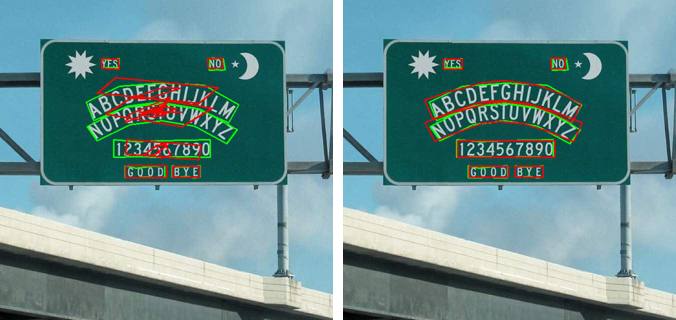

---Overall (Ground-truth vs Regular Method (EAST))---
Precision: 0.29, Recall: 0.71, HMean: 0.42

---Per Sample Metric---
---Matched---

MATCHED GT 0 and MATCHED PRED 1 IoU: 0.61, TIoU_Recall: 0.39, TIoU_Precision: 0.61

MATCHED GT 1 and MATCHED PRED 4 IoU: 0.84, TIoU_Recall: 0.83, TIoU_Precision: 0.84

MATCHED GT 2 and MATCHED PRED 5 IoU: 0.91, TIoU_Recall: 0.86, TIoU_Precision: 0.91

MATCHED GT 3 and MATCHED PRED 7 IoU: 0.85, TIoU_Recall: 0.83, TIoU_Precision: 0.85

MATCHED GT 6 and MATCHED PRED 10 IoU: 0.68, TIoU_Recall: 0.5, TIoU_Precision: 0.68

---Unmatched---
UNMATCHED GT 4 and UNMATCHED PRED 0 IoU: 0.39
UNMATCHED GT 4 and UNMATCHED PRED 2 IoU: 0.09
UNMATCHED GT 4 and UNMATCHED PRED 3 IoU: 0.06
UNMATCHED GT 4 and UNMATCHED PRED 6 IoU: 0.0
UNMATCHED GT 4 and UNMATCHED PRED 8 IoU: 0.0
UNMATCHED GT 4 and UNMATCHED PRED 9 IoU: 0.01
UNMATCHED GT 4 and UNMATCHED PRED 11 IoU: 0.0
UNMATCHED GT 4 and UNMATCHED PRED 12 IoU: 0.0
UNMATCHED GT 4 and UNMATCHED PRED 13 IoU: 0.0
UNMATCHED GT 4 

In [34]:
# Let's visualise the text detection results of ground-truth, regular text method (EAST) and irregular text method (CRAFT)
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": False,
}

regular_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_output/vis"
)
irregular_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/craft_output/vis"
)
intersect_images = set(os.listdir(regular_path)).intersection(os.listdir(irregular_path))
sel_img_id = random.sample(list(intersect_images), 1)[0]
print(f"Visualising result of {sel_img_id}.")

regular_pil_img = Image.open(os.path.join(regular_path, sel_img_id))
img_w, img_h = regular_pil_img.size
new_img_w, new_img_h = int(img_w / 2), int(img_h / 2)
regular_pil_img = regular_pil_img.resize((new_img_w, new_img_h))

irregular_pil_img = Image.open(os.path.join(irregular_path, sel_img_id))
irregular_pil_img = irregular_pil_img.resize((new_img_w, new_img_h))

grid_pil_img = Image.new("RGBA", (img_w + 10, new_img_h), (255, 255, 255, 255))
bg_w, bg_h = grid_pil_img.size
grid_pil_img.paste(regular_pil_img, (0, 0))
grid_pil_img.paste(irregular_pil_img, (new_img_w + 10, 0))
grid_pil_img.show()



gt_path = "/content/drive/My Drive/ArT/det.txt"
regular_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_output/east_output.txt"
)
irrregular_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/craft_output/craft_output.txt"
)
gt_dict = txt_to_dict(gt_path, True, sel_img_id=sel_img_id)
regular_det_dict = txt_to_dict(regular_txt_path, False, sel_img_id=sel_img_id)
irregular_det_dict = txt_to_dict(irrregular_txt_path, False, sel_img_id=sel_img_id)

print(f"---Overall (Ground-truth vs Regular Method (EAST))---")
regular_resDict = evaluation(gt_dict, regular_det_dict, eval_config)
precision, recall, hmean = (
    regular_resDict["method"]["precision"],
    regular_resDict["method"]["recall"],
    regular_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(regular_resDict, sel_img_id, False)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

print(f"---Overall (Ground-truth vs Irregular Method (CRAFT))---")
irregular_resDict = evaluation(gt_dict, irregular_det_dict, eval_config)
precision, recall, hmean = (
    irregular_resDict["method"]["precision"],
    irregular_resDict["method"]["recall"],
    irregular_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(irregular_resDict, sel_img_id, False)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)


### Text Recognition

Visualising result of gt_392_1.jpg.


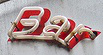

Ground-truth transcription: Bar
Predicted transcription using regular text method CRNN: ser
Predicted transcription using irregular text method ASTER: Bar

---Total Edit Distance (GT vs Regular)---
Total Edit Distance: 2
Total Edit Distance (Case Insensitive): 2

---Total Edit Distance (GT vs Irregular)---
Total Edit Distance: 0
Total Edit Distance (Case Insensitive): 0


In [35]:
# Let's visualise the text recognition results of ground-truth, regular text method (CRNN) and irregular text method (ASTER)
gt_path = "/content/drive/My Drive/ArT/rec.txt"
regular_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/crnn_output/crnn_output.txt"
)
irregular_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/aster_output/aster_output.txt"
)
img_path = "/content/drive/My Drive/ArT/selected_crop"
all_images = os.listdir(img_path)
sel_img_id = all_images[8]
print(f"Visualising result of {sel_img_id}.")

gt_trans, regular_trans, irregular_trans = vis_rec_res(gt_path, regular_path, irregular_path, sel_img_id)

word_pil_img = Image.open(os.path.join(img_path, sel_img_id))
word_pil_img.show()

print(f"Ground-truth transcription: {gt_trans}")
print(f"Predicted transcription using regular text method CRNN: {regular_trans}")
print(f"Predicted transcription using irregular text method ASTER: {irregular_trans}\n")

print(f"---Total Edit Distance (GT vs Regular)---")
total_edit, total_edit_ci = total_edit_distance([gt_trans], [regular_trans])
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}\n")

print(f"---Total Edit Distance (GT vs Irregular)---")
total_edit, total_edit_ci = total_edit_distance([gt_trans], [irregular_trans])
print(f"Total Edit Distance: {total_edit}")
print(f"Total Edit Distance (Case Insensitive): {total_edit_ci}")

### Text Spotting

Visualising result of gt_1038.jpg.


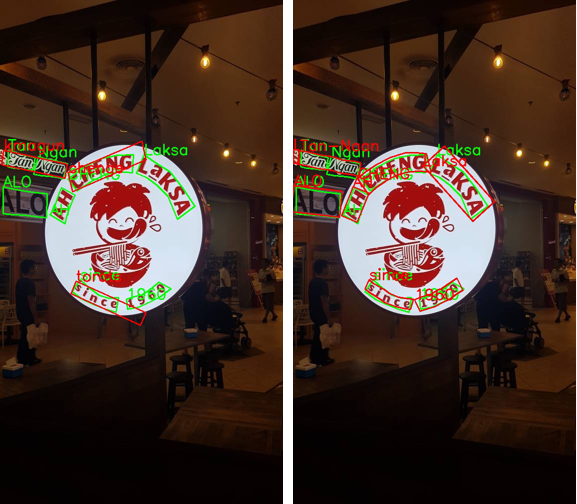

---Overall (Ground-truth vs Regular Method (EAST))---
Precision: 0.0, Recall: 0.0, HMean: 0

---Per Sample Metric---
---Unmatched---
UNMATCHED GT 0 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 0 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 0 and UNMATCHED PRED 2 IoU: 0.39
UNMATCHED GT 1 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 1 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 1 and UNMATCHED PRED 2 IoU: 0.42
UNMATCHED GT 2 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 2 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 2 and UNMATCHED PRED 2 IoU: 0.0
UNMATCHED GT 3 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 3 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 3 and UNMATCHED PRED 2 IoU: 0.0
UNMATCHED GT 4 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 4 and UNMATCHED PRED 1 IoU: 0.64
UNMATCHED GT 4 and UNMATCHED PRED 2 IoU: 0.0
UNMATCHED GT 5 and UNMATCHED PRED 0 IoU: 0.0
UNMATCHED GT 5 and UNMATCHED PRED 1 IoU: 0.01
UNMATCHED GT 5 and UNMATCHED PRED 2 IoU: 0.0
UNMATCHED GT 6 and UNMATCHED PRED 0 IoU: 0.51
UNMATCH

In [37]:
# Let's visualise the text spotting results of ground-truth, regular text method (EAST + CRNN) and irregular text method (CRAFT + ASTER)
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}
regular_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
   " 6/Signboard_OCR/pretrained_results/east_crnn_output/vis"
)
irregular_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
   " 6/Signboard_OCR/pretrained_results/craft_aster_output/vis"
)
intersect_images = set(os.listdir(regular_path)).intersection(os.listdir(irregular_path))
sel_img_id = list(intersect_images)[18]
print(f"Visualising result of {sel_img_id}.")

regular_pil_img = Image.open(os.path.join(regular_path, sel_img_id))
img_w, img_h = regular_pil_img.size
new_img_w, new_img_h = int(img_w / 2), int(img_h / 2)
regular_pil_img = regular_pil_img.resize((new_img_w, new_img_h))

irregular_pil_img = Image.open(os.path.join(irregular_path, sel_img_id))
irregular_pil_img = irregular_pil_img.resize((new_img_w, new_img_h))

grid_pil_img = Image.new("RGBA", (img_w + 10, new_img_h), (255, 255, 255, 255))
bg_w, bg_h = grid_pil_img.size
grid_pil_img.paste(regular_pil_img, (0, 0))
grid_pil_img.paste(irregular_pil_img, (new_img_w + 10, 0))
grid_pil_img.show()

gt_path = "/content/drive/My Drive/ArT/det.txt"
regular_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/east_crnn_output/east_crnn_output.txt"
)
irregular_txt_path = (
    "/content/drive/My Drive/Colab Notebooks/Chapter"
    " 6/Signboard_OCR/pretrained_results/craft_aster_output/craft_aster_output.txt"
)
gt_dict = txt_to_dict(gt_path, True, sel_img_id=sel_img_id)
regular_det_dict = txt_to_dict(regular_txt_path, True, sel_img_id=sel_img_id)
irregular_det_dict = txt_to_dict(irregular_txt_path, True, sel_img_id=sel_img_id)

print(f"---Overall (Ground-truth vs Regular Method (EAST))---")
regular_resDict = evaluation(gt_dict, regular_det_dict, eval_config)
precision, recall, hmean = (
    regular_resDict["method"]["precision"],
    regular_resDict["method"]["recall"],
    regular_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(regular_resDict, sel_img_id, False)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

print(f"---Overall (Ground-truth vs Irregular Method (CRAFT))---")
irregular_resDict = evaluation(gt_dict, irregular_det_dict, eval_config)
precision, recall, hmean = (
    irregular_resDict["method"]["precision"],
    irregular_resDict["method"]["recall"],
    irregular_resDict["method"]["hmean"],
)
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(irregular_resDict, sel_img_id, False)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)


<a name="conclusion"></a>
## Conclusion

In conclusion, this notebook provided a comprehensive overview of text detection, text recognition, and text spotting on the irregular text dataset, ArT Dataset. We focused on methods for regular text, specifically EAST and CRNN using PaddleOCR, as well as irregular text methods including CRAFT for text detection and ASTER (utilizing MMOCR) for text recognition. We highlighted the limitations of regular text methods when applied to irregular text datasets. This analysis provided valuable insights into the challenges posed by irregular text and the need for specialized techniques to address them effectively.
